# Experiment 1: Varsortability Experiment
This experiment seeks to **empirically validate the theoretical result** presented in the appendix of the paper "Beware of the Simulated DAG! Causal Discovery Benchmarks May Be Easy To Game" (Reisach et. all), which critizes the performance of the NOTEARS algorithm applied on real-world data. It explores how **varsortability**—the alignment between the order of increasing marginal variances and the causal order in a Directed Acyclic Graph (DAG)—impacts the accuracy of causal direction inference using an **MSE-based criterion**.

---


### Table of Contents:
- <a href='#1'>1. Experimental Setup </a>

- <a href='#2'>2. Data & Functions </a>
    - <a href='#2.1'>2.1 Load Data </a>
    - <a href='#2.2'>2.2 Helper Functions </a>

- <a href='#3'>3. Varsortability Experiments</a>
    - <a href='#3.1'>3.1 Experiment 1: Accuracy across different w-values and VA/VB ratios</a> 
    - <a href='#3.2'>3.2 Experiment 2: Compare Gaussian, Exponential, and Gumbel Noise</a> 
    - <a href='#3.3'>3.3 Experiment 3: Impact of Standardization on Causal Weights</a> 

# <a id='1'>1. Experimental Setup</a>
----

**Experimental Parameters:**
- **Variance Parameters ($V_A$ and $V_B$)**:
  - **$V_A$**: Variance of the noise term $N_A$ affecting variable $A$.
  - **$V_B$**: Variance of the noise term $N_B$ affecting variable $B$.
  - **$V_A/V_B$ Ratio**: Systematically varied to assess its impact on causal inference accuracy.

- **Causal Weight ($w$)**:
  - Represents the strength of the causal effect in the structural equation $B = wA + N_B$.
  - A **non-zero $w$** ensures the existence of a causal relationship between $A$ and $B$.

- **Number of Samples ($n\_samples$)**:
  - Specifies the size of the dataset for each simulation.
  - Larger sample sizes improve the estimation of variances and covariances, reducing randomness.

- **Number of Repeats ($n\_repeats$)**:
  - Determines how many independent simulations are run for each $V_A/V_B$ ratio.
  - More repeats provide robust averages for inference accuracy by minimizing random noise.

- **Ratios ($V_A/V_B$)**:
  - A range of values representing scenarios where $A$ has lower, similar, or higher variance compared to $B$.
  - Allows analysis of the effect of variance alignment on causal inference.


**Data Generation Process:**
- The experiment uses a **two-node causal model** where $A$ causes $B$:
  - $A = N_A$
  - $B = wA + N_B$
- Key Details:
  - $N_A$ and $N_B$ are independent noise terms with zero mean and variances $V_A$ and $V_B$, respectively.
  - $w$ is the causal weight determining the influence of $A$ on $B$.
  - By varying $V_A$ while keeping $V_B$ fixed, the experiment observes how changes in $V_A/V_B$ affect the accuracy of causal direction inference.


**Causal Direction Inference Method:**
- The method infers causality using the **MSE-based criterion**:
  1. **Model M1 (Assuming $A \to B$)**:
    - Total MSE: $\text{Var}(A) + \text{Var}(B - w_A)$
  2. **Model M2 (Assuming $B \to A$)**:
    - Total MSE: $\text{Var}(B) + \text{Var}(A - w_B)$
  3. **Inference Criterion**:
    - If $\text{MSE(M1)} < \text{MSE(M2)}$, infer $A \to B$.
- This approach assumes that the correct causal direction yields a lower total MSE due to better alignment with data variances and covariances.


**Theoretical Foundation:**
- A key theoretical result from Appendix A states that for the MSE-based inference method to **correctly identify $A \to B$**, the following condition must hold:
  
  $(1 - w^2) V_A < V_B$
  
- This defines the range of **$V_A/V_B$ ratios** where the inference method is reliable:
  - **For $V_A/V_B < 1 / (1 - w^2)$**: The method consistently infers $A \to B$ with 100% accuracy.
  - **For $V_A/V_B > 1 / (1 - w^2)$**: Accuracy decreases as the method starts incorrectly inferring $B \to A$.


**Role of the Causal Weight $w$:**

- A **higher $w$** (stronger causal influence):
  - Increases the **critical ratio** $1 / (1 - w^2)$, allowing the method to remain reliable over a **wider range** of $V_A/V_B$ ratios.
  - Enables the method to correctly infer causality even when $VA$ is relatively large compared to $VB$.
  
- A **lower $w$** (weaker causal influence):
  - Decreases the critical ratio, restricting reliability to smaller $V_A/V_B$ ratios.
  - Makes the method more sensitive to variance alignment.


# <a id='2'>2. Data & Functions</a>
---

## <a id='2.1'>2.1 Load data</a>

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from typing import Tuple, List, Dict, Union
import os

# Set random seed for reproducibility
np.random.seed(42)

# Define a single color palette excluding yellow
COLOR_PALETTE = ['blue', 'green', 'purple', 'orange', 'cyan', 'magenta']

# Define folder to save plots
PLOT_FOLDER = 'plots/'
os.makedirs(PLOT_FOLDER, exist_ok=True)

## <a id='2.2'>2.2 Helper Functions</a>

**General Functions:**

In [20]:
def generate_data(
    va: float,
    vb: float,
    w: float,
    n_samples: int = 1000,
    noise_type: str = 'gauss',
    standardize: bool = False
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate synthetic data for the two-node causal model A -> B:
        A = N_A
        B = w * A + N_B
    where N_A and N_B are independent noise terms with variances va and vb.

    Parameters:
    - va (float): Variance of noise term N_A affecting A.
    - vb (float): Variance of noise term N_B affecting B.
    - w (float): Causal weight from A to B.
    - n_samples (int): Number of data points to generate.
    - noise_type (str): Type of noise ('gauss', 'exponential', 'gumbel').
    - standardize (bool): Whether to standardize A and B after generation.

    Returns:
    - A (np.ndarray): Generated variable A.
    - B (np.ndarray): Generated variable B.
    """
    if noise_type == 'gauss':
        na = np.random.normal(0, np.sqrt(va), size=n_samples)
        nb = np.random.normal(0, np.sqrt(vb), size=n_samples)
    elif noise_type == 'exponential':
        na = np.random.exponential(scale=np.sqrt(va)/np.sqrt(2), size=n_samples) - np.sqrt(va)/np.sqrt(2)
        nb = np.random.exponential(scale=np.sqrt(vb)/np.sqrt(2), size=n_samples) - np.sqrt(vb)/np.sqrt(2)
    elif noise_type == 'gumbel':
        scale_na = np.sqrt(va / (np.pi**2 / 6))
        scale_nb = np.sqrt(vb / (np.pi**2 / 6))
        na = np.random.gumbel(loc=0, scale=scale_na, size=n_samples)
        nb = np.random.gumbel(loc=0, scale=scale_nb, size=n_samples)
    else:
        raise ValueError("Unsupported noise_type. Choose 'gauss', 'exponential', or 'gumbel'.")
    
    na = np.random.normal(0, np.sqrt(va), size=n_samples)
    nb = np.random.normal(0, np.sqrt(vb), size=n_samples)
    A = na
    B = w * A + nb

    if standardize:
        scaler = StandardScaler()
        data = np.vstack([A, B]).T
        scaler.fit(data)
        data_scaled = scaler.transform(data)
        A, B = data_scaled[:, 0], data_scaled[:, 1]

    return A, B

def get_accuracy_results(
    results: Dict[str, Dict[float, Dict[float, float]]],
    noise_type: str,
    w: float
) -> Dict[float, float]:
    """
    Retrieve accuracy results for a specific noise type and causal weight.

    Parameters:
    - results: Nested dictionary from run_experiment().
    - noise_type: The noise type to access ('gauss', 'exponential', 'gumbel').
    - w: The causal weight value.

    Returns:
    - Dict mapping VA/VB ratios to accuracy percentages.
    """
    return results[noise_type][w]

def infer_causal_direction(A: np.ndarray, B: np.ndarray) -> bool:
    """
    Infer causal direction using the MSE-based criterion.

    Parameters:
    - A (np.ndarray): Variable A.
    - B (np.ndarray): Variable B.

    Returns:
    - inferred_is_AtoB (bool): True if A -> B is inferred, False otherwise.
    """
    # Model M1: A -> B
    cov_AB = np.cov(A, B, bias=True)[0, 1]
    var_A = np.var(A, ddof=0)
    w_hat_m1 = cov_AB / var_A
    mse_m1 = var_A + np.var(B - w_hat_m1 * A, ddof=0)

    # Model M2: B -> A
    cov_BA = np.cov(B, A, bias=True)[0, 1]
    var_B = np.var(B, ddof=0)
    w_hat_m2 = cov_BA / var_B
    mse_m2 = var_B + np.var(A - w_hat_m2 * B, ddof=0)

    # Return True if M1 < M2 (predict A->B), else False
    return mse_m1 < mse_m2

def run_experiment(
    w_values: List[float],
    va_vb_ratios: List[float],
    n_samples: int = 2000,
    n_repeats: int = 1000,
    noise_types: Union[str, List[str]] = 'gauss',
    standardize: bool = False
) -> Dict[str, Dict[float, Dict[float, float]]]:
    """
    Run causal inference experiments with varying parameters.

    Parameters:
    - w_values (List[float]): List of causal weight values to test.
    - va_vb_ratios (List[float]): List of VA/VB ratios to test.
    - n_samples (int): Number of samples per simulation.
    - n_repeats (int): Number of repetitions per configuration.
    - noise_types (Union[str, List[str]]): Type(s) of noise ('gauss', 'exponential', 'gumbel').
    - standardize (bool): Whether to standardize A and B after generation.

    Returns:
    - results (Dict[str, Dict[float, Dict[float, float]]]): Nested dictionary containing accuracy percentages.
        Outer key: noise type
        Middle key: w value
        Inner key: VA/VB ratio
        Value: Accuracy percentage
    """
    if isinstance(noise_types, str):
        noise_types = [noise_types]
    
    results = {noise: {w: {} for w in w_values} for noise in noise_types}

    for noise in noise_types:
        print(f"\nRunning experiments for noise type: {noise}")
        for w in w_values:
            for ratio in va_vb_ratios:
                correct_count = 0
                for _ in range(n_repeats):
                    vb = 1.0
                    va = ratio * vb

                    if standardize:
                        A, B = generate_data(va, vb, w, n_samples, noise_type=noise, standardize=True)
                    else:
                        A, B = generate_data(va, vb, w, n_samples, noise_type=noise, standardize=False)

                    inferred_AtoB = infer_causal_direction(A, B)
                    if inferred_AtoB:
                        correct_count += 1

                accuracy = 100.0 * correct_count / n_repeats
                results[noise][w][ratio] = accuracy

    return results

def run_standardization_experiment(
    w_values: List[float],
    va: float = 1.0,
    n_samples: int = 2000,
    n_repeats: int = 1000,
    noise_type: str = 'gauss',
    standardize: bool = False
) -> Dict[float, float]:
    """
    Run experiment to test the impact of standardization on causal weight.

    Parameters:
    - w_values (List[float]): List of causal weight values to test.
    - va (float): Variance of noise term N_A affecting A.
    - n_samples (int): Number of samples per simulation.
    - n_repeats (int): Number of repetitions per causal weight.
    - noise_type (str): Type of noise ('gauss', 'exponential', 'gumbel').

    Returns:
    - results (Dict[float, float]): Dictionary containing accuracy percentages for each w.
        Key: w value
        Value: Accuracy percentage
    """
    results = {}
    for w in w_values:
        correct_count = 0
        for _ in range(n_repeats):
            vb = 1.0
            A, B = generate_data(va, vb, w, n_samples, noise_type, standardize)
            
            # Since va = vb =1, data is already standardized; no need to standardize again
            inferred_AtoB = infer_causal_direction(A, B)
            if inferred_AtoB:
                correct_count += 1

        accuracy = 100.0 * correct_count / n_repeats
        results[w] = accuracy
    
    return results

**Plot functions:**

In [21]:
def plot_experiment1(
    w_values: List[float],
    va_vb_ratios: List[float],
    results: Dict[float, Dict[float, float]],
    critical_ratios: Dict[float, float] = None,
    noise_type: str = 'gauss'
    ):
    """
    Plot accuracy versus VA/VB ratios for multiple causal weights in Experiment 1.

    Parameters:
    - w_values (List[float]): List of causal weight values.
    - va_vb_ratios (List[float]): List of VA/VB ratios.
    - results (Dict[float, Dict[float, float]]): Nested dictionary of results.
    - critical_ratios (Dict[float, float], optional): Critical ratios for each w.
    - noise_type (str): Type of noise used in the experiment.
    """
    plt.figure(figsize=(10, 6))
    
    for idx, w in enumerate(w_values):
        accuracies = list(results[w].values())
        plt.plot(
            va_vb_ratios,
            accuracies,
            marker='o',
            linestyle='-',
            color=COLOR_PALETTE[idx % len(COLOR_PALETTE)],
            label=f'w = {w}'
        )
        if critical_ratios and w in critical_ratios and critical_ratios[w] < max(va_vb_ratios):
            plt.axvline(
                x=critical_ratios[w],
                color=COLOR_PALETTE[idx % len(COLOR_PALETTE)],
                linestyle='--',
                alpha=0.7,
                label=f'Critical Ratio w={w}'
            )
    
    plt.axhline(y=50, color='red', linestyle='--', label='Chance Level (50%)')
    plt.title(f'Impact of VA/VB on Causal Inference Accuracy\nNoise={noise_type.capitalize()}', fontsize=14)
    plt.xlabel('VA / VB', fontsize=12)
    plt.ylabel('Accuracy in %', fontsize=12)
    plt.legend(fontsize=11, loc='upper right')
    plt.grid(True)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_FOLDER, 'Exp_1_1.png'), format='png', dpi=300)
    plt.show()

def plot_experiment2(
    va_vb_ratios: List[float],
    results: Dict[str, Dict[float, float]],
    w_fixed: float = 0.6
):
    """
    Plot accuracy versus VA/VB ratios for different noise types in Experiment 1c.

    Parameters:
    - va_vb_ratios (List[float]): List of VA/VB ratios.
    - results (Dict[str, Dict[float, float]]): Nested dictionary of results for each noise type.
    - w_fixed (float): Fixed causal weight used in the experiment.
    """
    plt.figure(figsize=(10, 6))
    
    for idx, (noise, acc_dict) in enumerate(results.items()):
        accuracies = list(acc_dict.values())
        plt.plot(
            va_vb_ratios,
            accuracies,
            marker='o',
            linestyle='-',
            color=COLOR_PALETTE[idx % len(COLOR_PALETTE)],
            label=f'Noise: {noise.capitalize()}'
        )
    
    plt.axhline(y=50, color='red', linestyle='--', label='Chance Level (50%)')
    plt.title(f'Influence of Noise Types\nw={w_fixed}', fontsize=14)
    plt.xlabel('VA / VB', fontsize=12)
    plt.ylabel('Accuracy in %', fontsize=12)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_FOLDER, 'Exp_1_2.png'), format='png', dpi=300)
    plt.show()

def plot_experiment3(
    w_values: List[float],
    results: Dict[Tuple[float, bool], Dict[float, float]],
    va_vb_ratios: List[float],
    noise_type: str = 'gauss'
):
    """
    Plot accuracy versus causal weight for multiple VA/VB ratios and standardization types.

    Parameters:
    - w_values (List[float]): List of causal weight values.
    - results (Dict[Tuple[float, bool], Dict[float, float]]): Accuracy results for each ratio and standardization type.
    - va_vb_ratios (List[float]): List of VA/VB ratios used in the experiment.
    - noise_type (str): Type of noise used in the experiment.
    """
    plt.figure(figsize=(10, 6))
    
    colors = ['blue', 'orange', 'green']
    markers = ['o', 's', '^']
    linestyles = ['-', '--']

    for i, ratio in enumerate(va_vb_ratios):
        for j, std_flag in enumerate([True, False]):
            label = f"VA/VB={ratio} | {'Standardized' if std_flag else 'Non-Standardized'}"
            linestyle = linestyles[j]
            color = colors[i]
            marker = markers[i]
            
            plt.plot(
                w_values,
                [results[(ratio, std_flag)][w] for w in w_values],
                marker=marker,
                linestyle=linestyle,
                color=color,
                label=label
            )

    plt.axhline(y=50, color='red', linestyle='--', label='Chance Level (50%)')
    plt.title(f'Standardized vs. Non-Standardized with Different VA/VB Ratios\nNoise={noise_type.capitalize()}', fontsize=14)
    plt.xlabel('Causal Weight (w)', fontsize=12)
    plt.ylabel('Accuracy in %', fontsize=12)
    plt.legend(fontsize=11, loc='upper right', bbox_to_anchor=(1, 0.8), ncol=2)
    plt.grid(True)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_FOLDER, 'Exp_1_3.png'), format='png', dpi=300)
    plt.show()


# <a id='3'>3. Varsortability Experiments</a>
---

## <a id='3.1'>3.1 Experiment 1: Accuracy across different w-values and VA/VB ratios</a>

In [22]:
def experiment1():
    """
    Experiment 1: Measure accuracy across different w-values and VA/VB ratios.
    """
    print("\nRunning Experiment 1: Vary w-values and Compare Across VA/VB Ratios")
    w_values = [0.3, 0.5, 0.7, 0.9]
    va_vb_ratios = np.linspace(0.1, 10.0, 100)
    noise_type = 'gauss'
    standardize = False

    critical_ratios = {}
    for w in w_values:
        if w < 1:
            critical_ratios[w] = 1 / (1 - w**2)
        else:
            critical_ratios[w] = np.inf

    results = run_experiment(
        w_values=w_values,
        va_vb_ratios=va_vb_ratios,
        noise_types=noise_type,
        standardize=standardize
    )
    extracted_results = {w: results[noise_type][w] for w in w_values}
    plot_experiment1(
        w_values=w_values,
        va_vb_ratios=va_vb_ratios,
        results=extracted_results,
        critical_ratios=critical_ratios,
        noise_type=noise_type
    )


Running Experiment 1: Vary w-values and Compare Across VA/VB Ratios

Running experiments for noise type: gauss


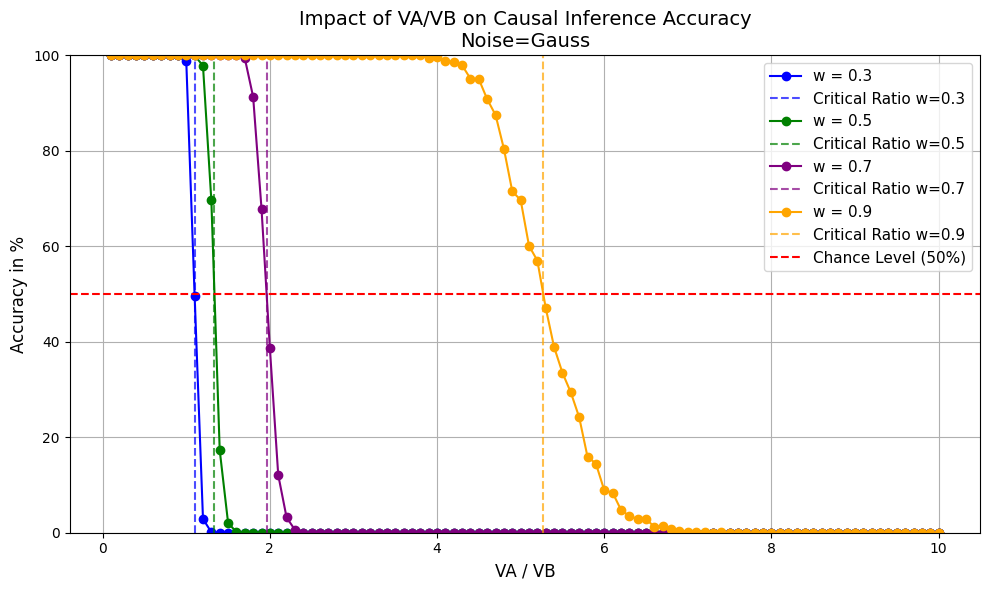

In [23]:
experiment1()

## <a id='3.2'>3.2 Experiment 2: Compare Gaussian, Exponential, and Gumbel Noise</a>

In [24]:
def experiment2():
    """
    Experiment 2: Compare accuracy between Gaussian, Exponential, and Gumbel noise for a fixed w.
    """
    print("\nRunning Experiment 2: Compare Gaussian, Exponential, and Gumbel Noise for w=0.6")
    w_fixed = 0.6
    va_vb_ratios = np.linspace(0.1, 5.0, 50)
    noise_types = ['gauss', 'exponential', 'gumbel']

    results = run_experiment(
        w_values=[w_fixed],
        va_vb_ratios=va_vb_ratios,
        noise_types=noise_types,
        standardize=False
    )
    plot_experiment2(
        va_vb_ratios=va_vb_ratios,
        results={noise: results[noise][w_fixed] for noise in noise_types},
        w_fixed=w_fixed
    )


Running Experiment 2: Compare Gaussian, Exponential, and Gumbel Noise for w=0.6

Running experiments for noise type: gauss

Running experiments for noise type: exponential

Running experiments for noise type: gumbel


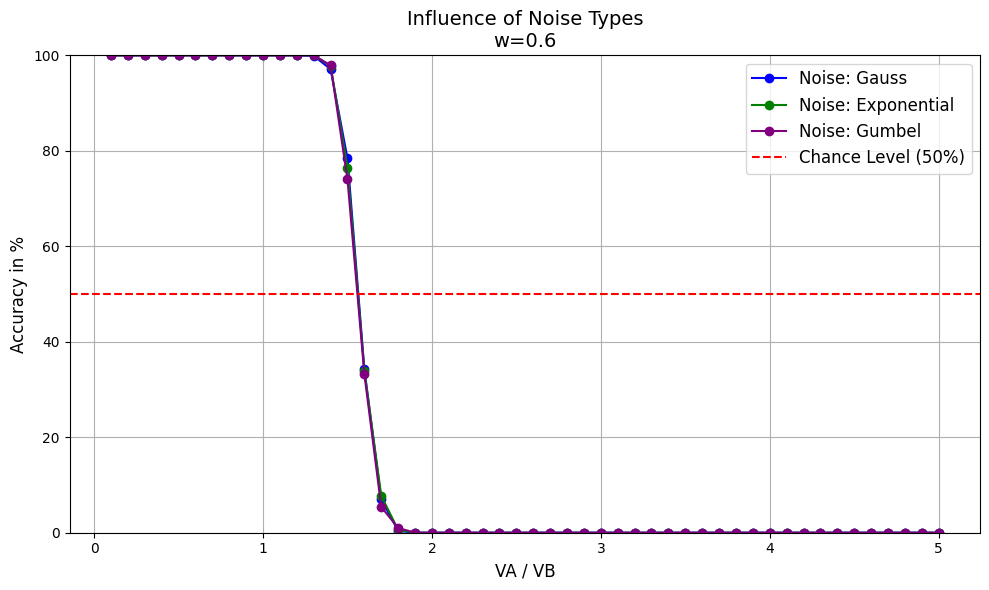

In [25]:
experiment2()

## <a id='3.3'>3.3 Experiment 3: Impact of Standardization on Causal Weights</a>

In [26]:
def experiment3():
    """
    Experiment 3: Compare standardized vs. non-standardized data
    for different causal weights and VA/VB ratios.
    """
    print("\nRunning Experiment 3: Impact of Standardization on Causal Weight with Different VA/VB Ratios")
    
    w_values = np.arange(0.0, 1.0, 0.01)
    noise_type = 'gauss'
    va_vb_ratios = [0.5, 1.0, 2.0]
    results = {}

    for ratio in va_vb_ratios:
        # Run experiments for standardized data
        standardized_results = run_standardization_experiment(
            w_values=w_values,
            va=ratio,
            noise_type=noise_type,
            standardize=True
        )
        
        # Run experiments for non-standardized data
        non_standardized_results = run_standardization_experiment(
            w_values=w_values,
            va=ratio,
            noise_type=noise_type,
            standardize=False
        )
        results[(ratio, True)] = standardized_results
        results[(ratio, False)] = non_standardized_results
    
    plot_experiment3(
        w_values=w_values,
        results=results,
        va_vb_ratios=va_vb_ratios,
        noise_type=noise_type
    )


Running Experiment 3: Impact of Standardization on Causal Weight with Different VA/VB Ratios


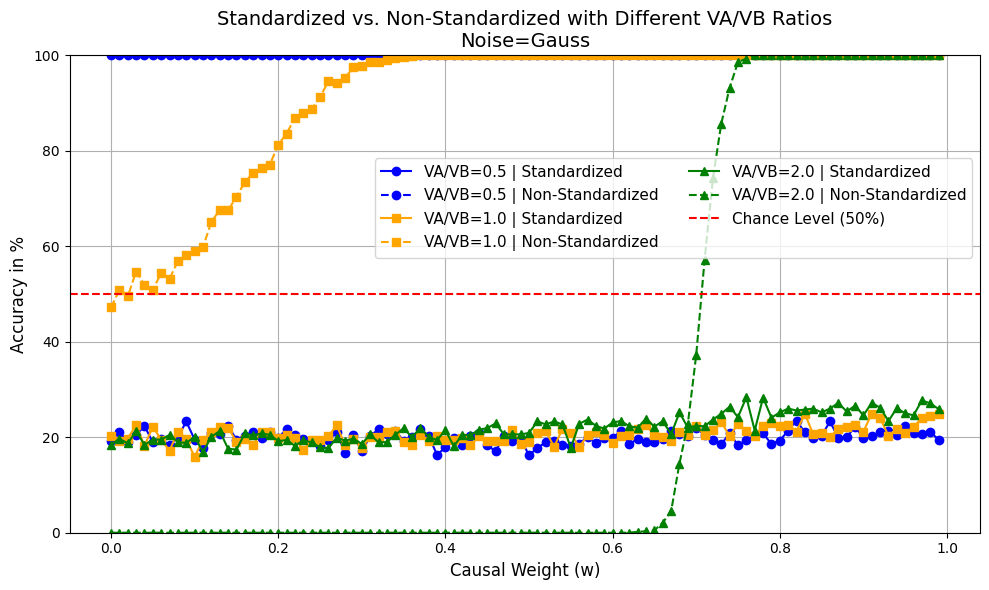

In [27]:
experiment3()